<a href="https://colab.research.google.com/github/jacopomanenti01/Graph-Neural-Networks/blob/main/GNN_for_Anti_Money_Laundering_in_Bitcoin_Node_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio torch-geometric
!pip install --upgrade scipy networkx



import pandas as pd
import matplotlib as mpt
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import torch
from tabulate import tabulate
from google.colab import files
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import NormalizeFeatures
from torch.optim import Adam








     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 12.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [7]:
!unzip elliptic

Archive:  elliptic.zip
  inflating: elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_features.csv  


In [8]:
%cd ./elliptic_bitcoin_dataset

/content/elliptic_bitcoin_dataset


# Dataset

As reported in [Kaggle](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set) "*The Elliptic Data Set maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.). The task on the dataset is to classify the illicit and licit nodes in the graph.

If you make use of the Elliptic Data Set in your research, please consider citing*"

Dataset Content

* Node: represents a transaction.
  - Each has 166 features
  - Labeled as ✅ licit, ❌ illicit or 🤷 unknown

* Edge: represents a flow of Bitcoins between transaction A and transaction B


Before we start, here are a couple concepts you should know for better understanding of the following code:



$$
\begin{array}{|l|l|p{5cm}|l|}
\hline
\textbf{Concept} & \textbf{Math Notation} & \textbf{Description} & \textbf{More Information} \\
\hline
\text{Graph} & G & \text{Defined as pair } G = (V, E), \text{ where } V \text{ is a set of vertices and } E \text{ is a set of edges} & \text{Wikipedia: Graph (discrete mathematics)} \\
& & \text{which are unordered pairs } v_1, v_2 \text{ of vertices.} & \\
\hline
\text{Degree} & deg & \text{Number of edges that are incident to a vertex.} & \text{Wikipedia: Degree (graph theory)} \\
\hline
\text{Component} & & \text{Connected subgraph that is not part of any larger connected subgraph.} & \text{Wikipedia: Component (graph theory)} \\
\hline
\end{array}
$$

🚨 In the following notebook we will always call the graph G, the set of nodes V and the set of edges E. 🚨

# Overview

Let's start by getting an overview of the datasets.



In [9]:
elliptic_txs_features = pd.read_csv('./elliptic_txs_features.csv', header=None)
elliptic_txs_classes = pd.read_csv('./elliptic_txs_classes.csv')
elliptic_txs_edgelist = pd.read_csv('./elliptic_txs_edgelist.csv')



In [ ]:
elliptic_txs_features

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


In [ ]:
print(f"{elliptic_txs_features.shape[0]:8,}")

 203,769


In [10]:
# Rename the elliptic_txs_features columns
elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)  {elliptic_txs_edgelist.shape[1]:4,} (cols)
""")

Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



Let's get an overview on the distribution of the classes.



In [ ]:
elliptic_txs_classes["class"].value_counts()

,count
class,
unknown,157205
2,42019
1,4545


In [11]:
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True)

,proportion
class_mapped,
unknown,77.148634
licit,20.620899
illicit,2.230467


See labels

In [ ]:

percentage_distribution = round(100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True), 2)
class_counts = elliptic_txs_classes['class_mapped'].value_counts()


classes_df = pd.DataFrame({
    'Class Mapped': elliptic_txs_classes['class_mapped'].unique(),
    'Class Raw': elliptic_txs_classes['class'].unique(),
    'Counts': class_counts.values,
    'Percentage': percentage_distribution.values,
})
classes_df

,Class Mapped,Class Raw,Counts,Percentage
0,unknown,unknown,157205,77.15
1,licit,2,42019,20.62
2,illicit,1,4545,2.23


In [ ]:
num_nodes = elliptic_txs_features.shape[0]
num_edges = elliptic_txs_edgelist.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

Number of nodes: 203,769
Number of edges: 234,355


In [ ]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, 'txId1', 'txId2')


In [ ]:
# Take a subgraph for connectivity metrics computations


num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")
sub = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(sub)



print(f"Giant component - Number of nodes: {G_sub.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_sub.number_of_edges():,}")


Number of connected components: 49
Giant component - Number of nodes: 7,880
Giant component - Number of edges: 9,164


# Utilis Functions

In [ ]:
def get_color_map(top , metric ):
  """
    Multiplies two numbers and returns the result.

    Args:
        top (pd.Series): list of top node metric.
        metric (dict): connectivity metric.

    Returns:
        G: subgraph containig the top nodes.
        norm: The normalized color map used as input to the colorbar.
        node_color_norm: The normalized color map for the nodes colors.
    """

  top_nodes = top.tolist()
  # create the subgraph
  G_subgraph = G.subgraph(top_nodes)
  # create the color map
  node_color = [metric[node] for node in top_nodes]
  norm = mpt.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
  node_color_norm = [norm(value) for value in node_color]


  return G_subgraph,norm, node_color_norm


In [29]:
import random

def set_seed(seed):
    """
    Fix the random seed for reproducibility.

    Parameters:
    seed (int): The seed value to use.
    """
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (for single GPU)
    torch.cuda.manual_seed_all(seed)  # PyTorch GPU (for all GPUs)
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable benchmark mode for reproducibility

In [30]:
from sklearn.manifold import TSNE

def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 8))
    for i in range(len(set(labels))):
        indices = labels == i
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f'Class {i}', alpha=0.7)
    plt.legend()
    plt.title(title)
    plt.show()

# 🔍 Exploratory Data Analysis (EDA)


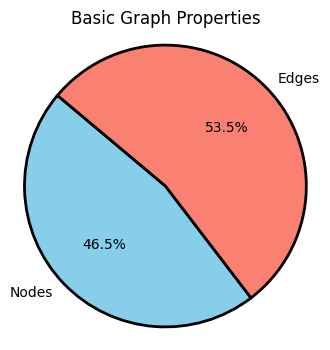

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sizes = [num_nodes, num_edges]
labels = ['Nodes', 'Edges']
colors = ['skyblue', 'salmon']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        wedgeprops = {'edgecolor' : 'black',
                      'linewidth': 2,
                      'antialiased': True})
plt.title('Basic Graph Properties')
plt.axis('equal')
plt.show()

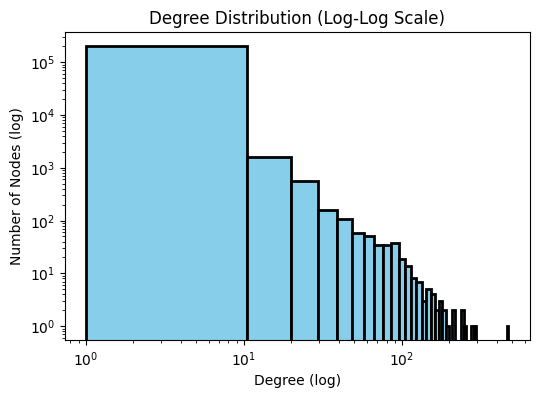

In [ ]:
# --- Degree Distribution (Log-Log Scale) ---
plt.figure(figsize=(6, 4))
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black', linewidth=2.0)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')
plt.show()

# Graph connectivity

Shortest paths length distribution in the giant component


In [ ]:
paths = dict(nx.shortest_path_length(G_sub))
# If neither the source nor target are specified, return an iterator over (source, dictionary)
# where dictionary is keyed by target to shortest path length from source to that target.
paths_val = [l for val in paths.values() for l in val.values()]
plt.figure(figsize=(6, 4))
plt.hist(paths_val, bins = 50, edgecolor = "black")
plt.title("Shortest Path Length Distribution")
plt.xlabel("Shortest Path Length")
plt.ylabel("Number of Nodes")
plt.show()



Degree Centrality

In [ ]:
degree_centrality = nx.degree_centrality(G_sub)
top_ten_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10] # sort by degree
dp_top_ten_degree_centrality = pd.DataFrame(top_ten_degree_centrality, columns=['node', 'degree_centrality'])


# create the color map
G_subgraph, norm, node_color_norm= get_color_map(dp_top_ten_degree_centrality["node"],degree_centrality )

# Plot top degree
print("Top 10 node centrality")
print("##########")
print(dp_top_ten_degree_centrality)

Top 10 node centrality
##########
        node  degree_centrality
0      89273           0.036680
1  232438397           0.020434
2    2881273           0.018150
3  230658142           0.017007
4    2758467           0.013453
5    2881274           0.012311
6  232029206           0.007615
7   43560505           0.006346
8    2880930           0.006219
9   27405707           0.005077


<ipython-input-22-213f3490c8cc>:4: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Degree Centrality')


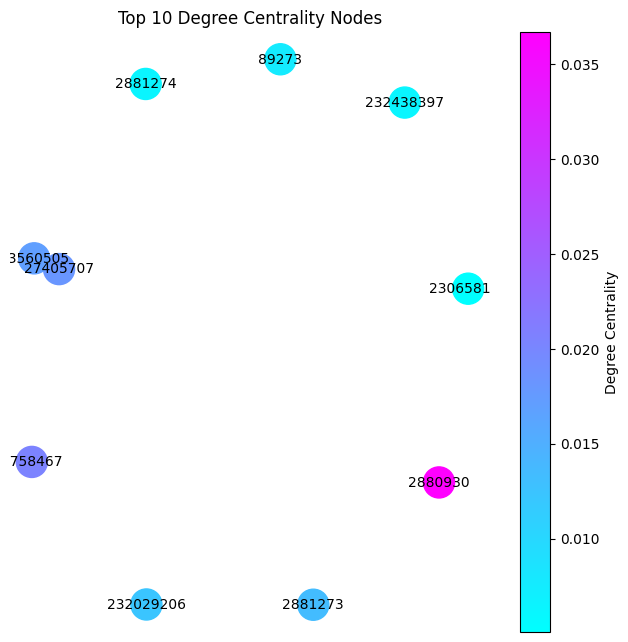

In [ ]:
plt.figure(figsize=(6, 6))
nx.draw(G_subgraph, with_labels = True,edge_color = "grey", node_size = 500,  font_size = 10, node_color = node_color_norm , cmap= mpt.cm.cool )
plt.title('Top 10 Degree Centrality Nodes')
plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Degree Centrality')
plt.show()

Betweeness centrality

In [ ]:
betweenness_centrality= nx.betweenness_centrality(G_sub)

TypeError: sorted expected 1 argument, got 2

In [ ]:
top_betweenness_centrality = sorted(betweenness_centrality.items(), key= lambda x:x[1], reverse = True )[:10]
pd_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns = ['node', 'betweenness_centrality'])


# create the color map
G_subgraph, norm, node_color_norm= get_color_map(pd_top_betweenness_centrality["node"],betweenness_centrality )

# Plot top degree
print("Top 10 node centrality")
print("##########")
print(pd_top_betweenness_centrality)

Top 10 node centrality
##########
        node  betweenness_centrality
0      89273                0.485234
1  232438397                0.296735
2    2758467                0.164410
3    2881273                0.156171
4    2881274                0.135059
5    2893846                0.104127
6  230402893                0.092297
7  230658142                0.087068
8   34174548                0.081942
9    2880930                0.078085


<ipython-input-32-cf3d4502fbdb>:4: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Betweenness Centrality')


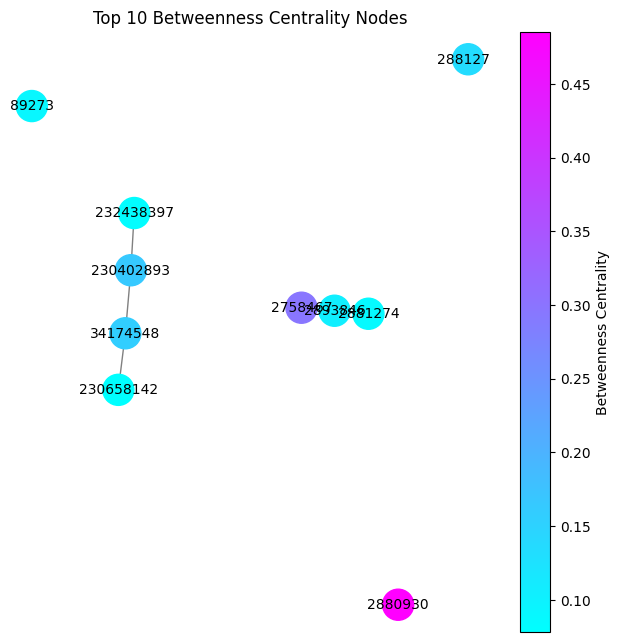

In [ ]:
plt.figure(figsize=(6, 6))
nx.draw(G_subgraph, with_labels = True, edge_color = "grey", node_size = 500, font_size = 10, node_color=node_color_norm, cmap=mpt.cm.cool)
plt.title('Top 10 Betweenness Centrality Nodes')
plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Betweenness Centrality')
plt.show()

Closeness centrality

In [ ]:
closeness_centrality = nx.closeness_centrality(G_sub)
top_ten_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
pd_top_closeness_centrality = pd.DataFrame(top_ten_closeness_centrality, columns=['node', 'closeness_centrality'])

# print
print("top 10 Closeness Centrality")
print("##########")
print(pd_top_closeness_centrality)


top 10 Closeness Centrality
##########
        node  closeness_centrality
0      89273              0.162511
1  232438397              0.155365
2  230438845              0.151394
3  230439793              0.151394
4  230683551              0.149009
5  230537117              0.148888
6  230451730              0.147738
7  232031824              0.146728
8  203465969              0.146725
9  232054853              0.146205


<ipython-input-35-67a4616262c9>:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Closeness Centrality')


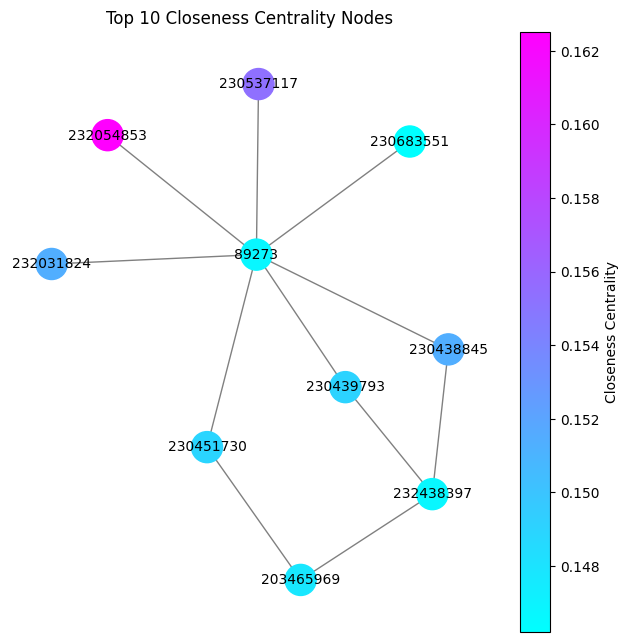

In [ ]:
G_subgraph, norm, node_color_norm= get_color_map(pd_top_closeness_centrality["node"],closeness_centrality )
# Plot
plt.figure(figsize=(6, 6))
nx.draw(G_subgraph, with_labels = True,edge_color = "grey", node_size = 500,  font_size = 10, node_color = node_color_norm , cmap= mpt.cm.cool )
plt.title('Top 10 Closeness Centrality Nodes')
plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Closeness Centrality')
plt.show()

# Graph visualization

In [ ]:
# Identify nodes that are top in each centrality measure and their combinations.
top_nodes_degree = set([node for node, _ in top_ten_degree_centrality])
top_nodes_betweenness = set([node for node, _ in top_betweenness_centrality])
top_nodes_closeness = set([node for node, _ in top_ten_closeness_centrality])

top_nodes_degree_betweenness = top_nodes_degree & top_nodes_betweenness
top_nodes_closeness_and_degree = top_nodes_closeness & top_nodes_degree
top_nodes_closeness_and_betweenness = top_nodes_closeness & top_nodes_betweenness
top_nodes_all_three = top_nodes_closeness & top_nodes_degree & top_nodes_betweenness

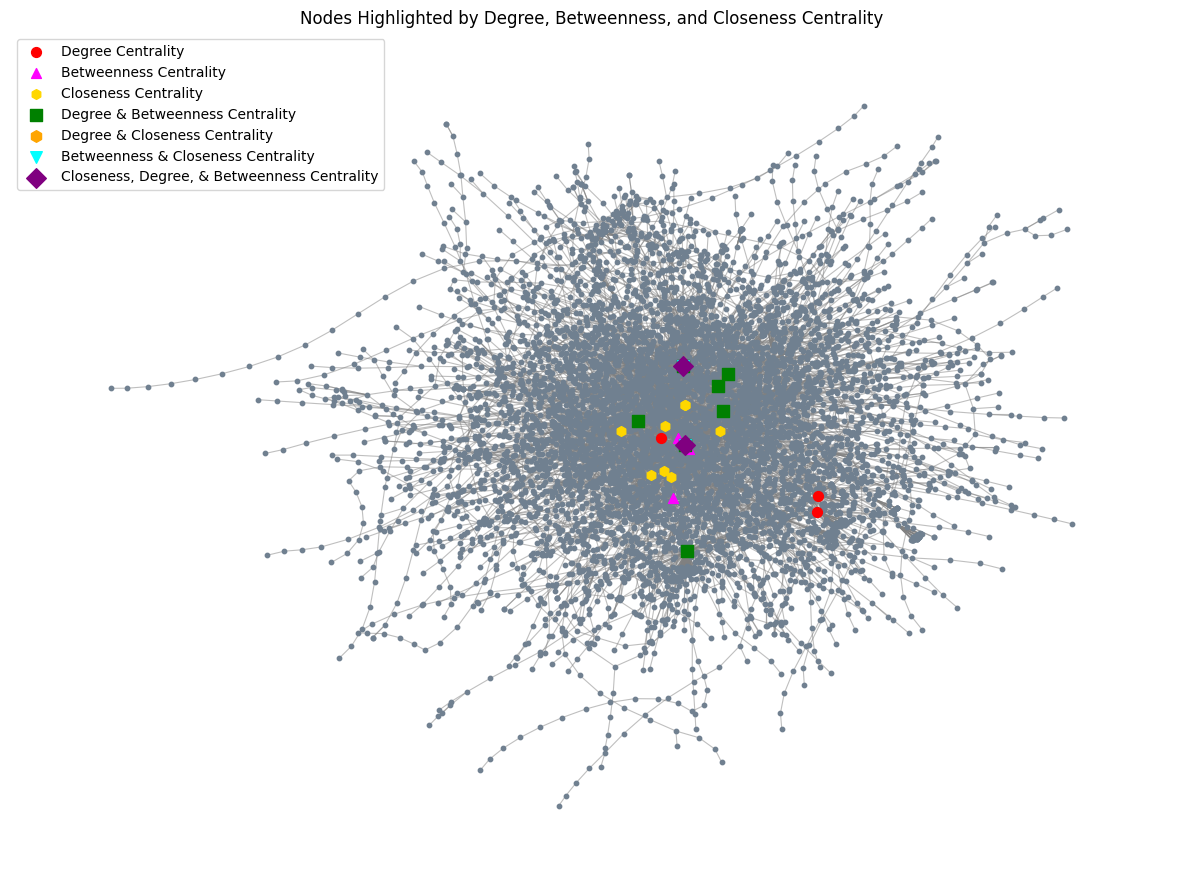

In [ ]:
plt.figure(figsize=(15, 11))

pos = nx.spring_layout(G_sub)
# Draw all nodes first.
nx.draw_networkx_nodes(G_sub,pos,  node_color='slategrey', node_size=10)

# Draw nodes with specific centrality measures.
nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_degree - top_nodes_degree_betweenness - top_nodes_closeness_and_degree),
                       node_color='red', node_size=50, node_shape='o', label='Degree Centrality')


nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_betweenness - top_nodes_degree_betweenness - top_nodes_closeness_and_betweenness),
                       node_color='magenta', node_size=50, node_shape='^', label='Betweenness Centrality')


nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_closeness - top_nodes_closeness_and_degree - top_nodes_closeness_and_betweenness),
                       node_color='gold', node_size=50, node_shape='h', label='Closeness Centrality')

nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_degree_betweenness), node_color='green', node_size=80, node_shape='s',
                       label='Degree & Betweenness Centrality')

nx.draw_networkx_nodes(G_sub, pos, nodelist=list(top_nodes_closeness_and_degree), node_color='orange', node_size=70, node_shape='h',
                       label='Degree & Closeness Centrality')

nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_closeness_and_betweenness), node_color='cyan', node_size=70, node_shape='v',
                       label='Betweenness & Closeness Centrality')

nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_all_three), node_color='purple', node_size=100, node_shape='D',
                       label='Closeness, Degree, & Betweenness Centrality')

# Draw edges.
nx.draw_networkx_edges(G_sub,pos, width=0.8, edge_color='gray', alpha=0.5)

plt.axis('off')
plt.title('Nodes Highlighted by Degree, Betweenness, and Closeness Centrality')
plt.legend(scatterpoints=1)
plt.show()

# Create the Data Object for Pytorch Geometric


Set the device

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
tx_id_mapping = {key: idx  for idx, key in enumerate(elliptic_txs_features['txId'])}

elliptic_txs_edgelist['Id1'] = elliptic_txs_edgelist['txId1'].map(tx_id_mapping)
elliptic_txs_edgelist['Id2'] = elliptic_txs_edgelist['txId2'].map(tx_id_mapping)


edge_index = torch.tensor(elliptic_txs_edgelist[['Id1', 'Id2']].values.T, dtype=torch.long)
edge_index

tensor([[     0,      2,      4,  ..., 201921, 201480, 201954],
        [     1,      3,      5,  ..., 202042, 201368, 201756]])

In [14]:
nodes_features = torch.tensor(elliptic_txs_features.drop('txId', axis=1).values, dtype=torch.float)
nodes_features.shape

torch.Size([203769, 166])

In [15]:
mapped_labels = elliptic_txs_classes["class"].replace({"unknown":"0"})
mapped_labels = mapped_labels.astype(int)
mapped_labels.value_counts()

,count
class,
0,157205
2,42019
1,4545


In [17]:
labels = torch.tensor(mapped_labels.values, dtype=torch.long)
labels

tensor([0, 0, 0,  ..., 1, 0, 0])

In [18]:
# Create a pythorch geometric data object
from torch_geometric.data import Data

data = Data(x=nodes_features,
            edge_index=edge_index,
            y=labels)


In [34]:
data.edge_index.T

tensor([[     0,      1],
        [     2,      3],
        [     4,      5],
        ...,
        [201921, 202042],
        [201480, 201368],
        [201954, 201756]])

# Train, Validation, Test masks


In [19]:

def load_split_dataset(data , train_ratio=0.6, val_ratio=0.2):
    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)

    train_size = int(train_ratio * num_nodes)
    val_size = int(val_ratio * num_nodes)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]


    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    data.train_mask[train_indices] = True
    data.val_mask[val_indices] = True
    data.test_mask[test_indices] = True

    # Check that the splits have no overlap
    assert torch.sum(data.train_mask & data.val_mask) == 0, "Train and validation masks overlap!"
    assert torch.sum(data.train_mask & data.test_mask) == 0, "Train and test masks overlap!"
    assert torch.sum(data.val_mask & data.test_mask) == 0, "Validation and test masks overlap!"

    print(f"Train: {data.train_mask.sum().item()}, Val: {data.val_mask.sum().item()}, Test: {data.test_mask.sum().item()}")
    return data

In [20]:
data = load_split_dataset(data)

data = data.to(device)

Train: 122261, Val: 40753, Test: 40755


## Statistics

In [21]:
cond1 = (data.y == 1)
cond2 = (data.y == 2)

tot_illicit = cond1.sum().item()
tot_licit = cond2.sum().item()
tot = tot_illicit+ tot_licit


In [22]:
train_illicit = (data.y[data.train_mask == True] == 1).sum().item()
train_licit = (data.y[data.train_mask == True] == 2).sum().item()
train_unkwon = (data.y[data.train_mask == True] == 0).sum().item()

val_illicit = (data.y[data.val_mask == True] == 1).sum().item()
val_licit = (data.y[data.val_mask == True] == 2).sum().item()
val_unkwon = (data.y[data.val_mask == True] == 0).sum().item()


test_illicit = (data.y[data.test_mask == True] == 1).sum().item()
test_licit = (data.y[data.test_mask == True] == 2).sum().item()
test_unkwon = (data.y[data.test_mask == True] == 0).sum().item()



split_dic = {
    "#unkwon": [train_unkwon, val_unkwon, test_unkwon],
    "#licit": [train_licit, val_licit, test_licit],
    "#illicit": [train_illicit, val_illicit, test_illicit],
    "%licit": [100 * train_licit / tot_licit, 100 * val_licit / tot_licit, 100 * test_licit / tot_licit],
    "%illicit": [100 * train_illicit / tot_illicit, 100 * val_illicit / tot_illicit, 100 * test_illicit / tot_illicit],
    "licti + illicit": [train_licit + train_illicit, val_licit + val_illicit, test_licit + test_illicit],
    "%licti + illicit": [ 100*(train_licit + train_illicit)/tot, 100*(val_licit + val_illicit)/tot, 100*(test_licit + test_illicit)/tot]
}

split_df = pd.DataFrame(split_dic, index=["train", "val", "test"])
split_df


,#unkwon,#licit,#illicit,%licit,%illicit,licti + illicit,%licti + illicit
train,94367,25159,2735,59.875295,60.176018,27894,59.904647
val,31383,8465,905,20.145648,19.911991,9370,20.122842
test,31455,8395,905,19.979057,19.911991,9300,19.972511


The percentages respects the splitting condition we have set.
Maybe a more balancing could be better

# Model

In [23]:
import torch_geometric.transforms as T

transform = T.Compose([T.NormalizeFeatures()])
data = transform(data)
print(data.is_directed())
data.x[:-1]

True


tensor([[0.0066, 0.0060, 0.0060,  ..., 0.0060, 0.0060, 0.0060],
        [0.0066, 0.0060, 0.0060,  ..., 0.0061, 0.0061, 0.0061],
        [0.0066, 0.0061, 0.0061,  ..., 0.0061, 0.0061, 0.0061],
        ...,
        [0.0274, 0.0057, 0.0057,  ..., 0.0057, 0.0050, 0.0050],
        [0.0276, 0.0058, 0.0058,  ..., 0.0058, 0.0058, 0.0058],
        [0.0278, 0.0058, 0.0058,  ..., 0.0058, 0.0066, 0.0066]])

Use a GCN Layer

In [24]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class MyMPL(torch.nn.Module):
  def __init__(self, input_dim, hidden_channels, output_dim):
    super(MyMPL, self).__init__()

    self.lin1 = torch.nn.Linear(input_dim, hidden_channels)
    self.lin2 = torch.nn.Linear(hidden_channels, output_dim)

  def forward(self, x):
    x = self.lin1(x)
    x = F.relu(x)
    x = self.lin2(x)
    return x

class MyGCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MyGCN, self).__init__()

        # initialize the layers
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.mlp = MyMPL(hidden_channels, hidden_channels, 3)

    def forward(self, x , edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing
        x = self.conv2(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)

        # MPL layer
        x = self.mlp(x)

        # Output layer
        x = F.softmax(x, dim=1)

        return x

    def get_embeddings(self, data, before = False):
      x, edge_index = data.x, data.edge_index
      x = self.conv1(x, edge_index)
      x = x.relu()
      x = self.conv2(x, edge_index)

      # get the embeddings of the last GCN
      if before:
        return x

      # get the embeddings of the last layer
      x = self.mlp(x)

      return x

# what are the hidden_channels?

model = MyGCN(hidden_channels=64)
print(model)

MyGCN(
  (conv1): GCNConv(166, 64)
  (conv2): GCNConv(64, 64)
  (mlp): MyMPL(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=3, bias=True)
  )
)


# Train GNN

In [25]:
model = model.to(device)
data = data.to(device)
learning_rate = 0.01
opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


In [33]:
def train():
  model.train()
  opt.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  opt.step()
  return loss

# Test

In [32]:
def test():
  model.eval()
  with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  return test_acc, pred

# Let's gooo

In [34]:
# Set the seed for reproducibility
seed = 42
set_seed(seed)

losses = []
for epoch in range(0, 1001):
  loss = train()
  losses.append(loss)
  if epoch % 100 == 0:
    print(f"The current loss is {loss:.4f}")

The current loss is 1.1163


KeyboardInterrupt: 

add a visualization
add a tqmd bar

# Time to test

In [36]:
test_acc, pred = test()
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7718


In [37]:
y_test = pred[data.test_mask].cpu().numpy()
y_test

array([0, 0, 0, ..., 0, 0, 0])

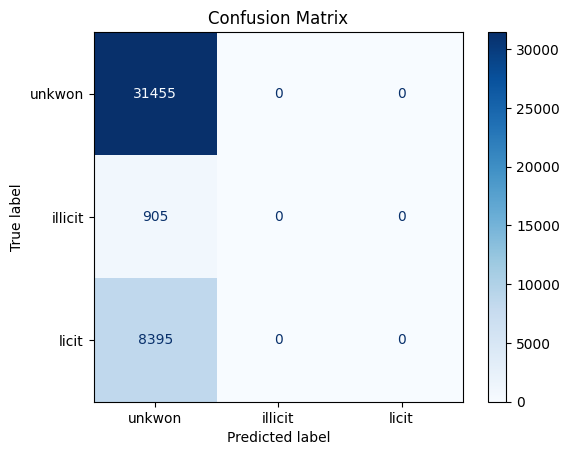

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# Generate the confusion matrix
cm = confusion_matrix(data.y[data.test_mask].cpu(), y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["unkwon", 'illicit', 'licit'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


The model is entirely biased towards predicting the unknown class for all inputs, regardless of the actual class.

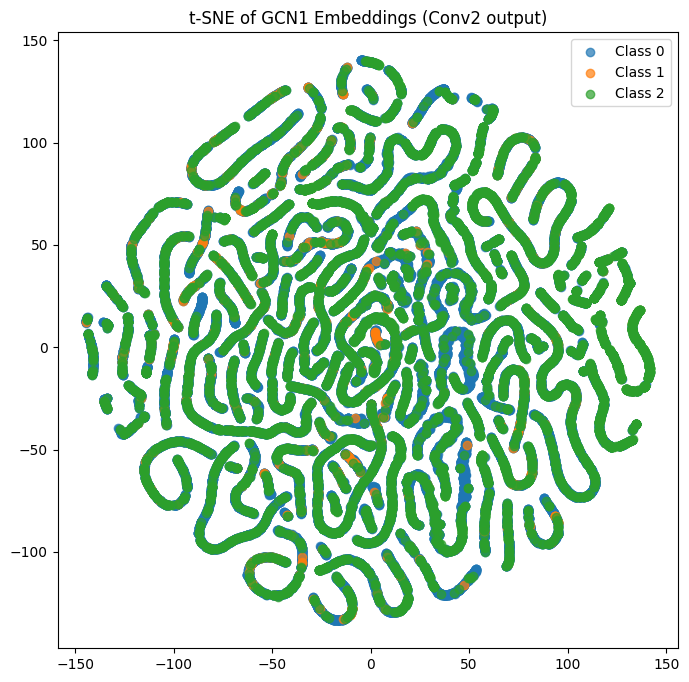

In [90]:
with torch.no_grad():
  test_embeddings = model.get_embeddings(data, before = True)[data.test_mask].cpu().numpy()

plot_tsne(test_embeddings, data.y[data.test_mask].cpu().numpy(), 't-SNE of GCN1 Embeddings (Conv2 output)')

# To do

- [ ] Balance the illicit/licit in the splitting
- [ ] visualize node embeddings